# Implied Volatility Calculator

### Black Scholes model
$C=\Phi(d_1)S - \Phi(d_2)Ke^{-rt}$ \
$P = \Phi(-d_2)Ke^{-rt} - \Phi(-d_1)S$ \
$d_1 = \frac{1}{\sigma \sqrt(t)}[log(\frac{S}{K}) + (r + \frac{\sigma^2}{2})t]$ \
$d_2 = d_1 - \sigma \sqrt(t) $

Say we have observed a call price $C_0$ \
and we are looking for a value $\sigma$, such that \
$\Phi(d_1)S - \Phi(d_2)Ke^{-rt} - C_0 = 0$

note that we need a derivative of C w.r.t $\sigma$ \
$\nu = \frac{\partial C}{\partial \sigma} = S \phi(d_1)\sqrt{t}$

##### Newton's method is used to solve for $\sigma$

In [2]:
from numpy import sqrt, exp, log, pi
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import datetime as dt
from datetime import date,datetime,timedelta
import warnings
#from scipy.interpolate import griddata
import plotly.graph_objects as go
from arch import arch_model
import nbformat
from matplotlib.colors import Normalize
%matplotlib inline
import plotly.io as pio
pio.renderers.default = "notebook_connected"
warnings.filterwarnings("ignore")

## Implied Volatility Calculator

In [206]:
class IVCalculator:
    def __init__(self, ticker, option_type, oi_lower_bound):
        self.ticker = ticker
        self.option_type = option_type
        self.oi_lower_bound = oi_lower_bound
        self.S_ticker = self.get_last_closing_price()
        self.r_1y = self.get_interest_rate()
        self.data_options = self.load_options_data()
        self.creation_time = dt.datetime.now()
    def __str__(self):
        return(f"Ticker: {self.ticker}\n"
               f"Option Type: {self.option_type}\n"
               f"Lower Bound for Open Interest: {self.oi_lower_bound} \n"
               f"Object created at: {self.creation_time.strftime('%A, %Y-%m-%d %H:%M:%S')}")
    
    def _print_creation_time(self):
        print("---------------------------------------------------------------------------------- \n"
              f"Object was created at: {self.creation_time.strftime('%A, %Y-%m-%d %H:%M:%S')}. \n"
              f"The market is open from 9:30 CET to 22:00 CET (Monday - Friday). \n"
              f"The IV Calculator is only designed for use during market hours. \n"
              "----------------------------------------------------------------------------------")

    def get_last_closing_price(self):
        """
        Downloads the latest spot price for the given ticker.
        """
        return yf.download(self.ticker)["Close"].iloc[-1].iat[-1]
    def get_interest_rate(self):
        """
        Downloads the most recent 1-year US-T yield.
        """
        return yf.download("^IRX")["Close"].iloc[-1].iat[-1] / 100
    def load_options_data(self):
        """
        Auxiliary function to load data and drop missing values. 
        """
        data = self.options_data(self.ticker, self.option_type, self.oi_lower_bound)
        return data.dropna()
    def options_data(self, ticker, option_type="call", oi_lower_bound=100):
        """
        Downloads the options data based on specified ticker, option type and
        minimum value of open interest (oi_lower_bound). Lower bound for open
        interest serves the purpose of disregarding illiquied, barely trade
        option contracts. Lowering the OI lower bound may result in lower
        ability of the algorithm to solve for the correct IV. 
        """
        asset = yf.Ticker(ticker)
        exp_dates = asset.options
        data = pd.DataFrame()

        for exp in exp_dates:
            options = asset.option_chain(exp)
            calls = options.calls
            calls["optionType"] = "call"
            puts = options.puts
            puts["optionType"] = "put"
            d = pd.concat([calls, puts])
            d["expiration"] = pd.to_datetime(exp) + pd.DateOffset(hours=23, minutes=59, seconds=59)
            data = pd.concat([data, d])

        data["dte"] = (data["expiration"] - dt.datetime.today()).dt.days + 1
        data = data[["strike", "lastPrice", "volume", "openInterest", "optionType", "dte", "impliedVolatility"]]
        data = data[data["openInterest"] > oi_lower_bound]

        if option_type == "call":
            return data[data["optionType"] == "call"]
        elif option_type == "put":
            return data[data["optionType"] == "put"]
        else:
            return data
    def objective_function(self, sigma, args):
        """
        Objective function for later optimization. Takes the theoretical
        option price(option_price) and the price observed on the market (price)
        and subtracts one from another.
        """
        S, K, r, t, price = args
        return self.option_price(sigma, S, K, r, t, type=self.option_type) - price

    def calculate_vega(self, sigma, args):
        """ 
        Calculates vega, a derivative of the option price according to
        BS fomula w.r.t sigma. It is necessary since the Newton's
        algorithm requires a derivative of a function as an input.
        """
        S, K, r, t = args[:4]

        d1 = (np.log(S / K) + (r + sigma ** 2 / 2.) * t) / (sigma * np.sqrt(t))
        return S * norm.pdf(d1) * np.sqrt(t)
    def newtons_method(self, f, fprime, R=0, max_iter=1000, tol=1e-3, args=[], debug=False):
        """ 
        Newton's algorithm, which will solve numerically for the value of sigma.
        """
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error", RuntimeWarning)
                count, epsilon = 0, 1

                while epsilon >= tol:
                    count += 1
                    if count >= max_iter:
                        print('Forced exit, the loop runs away')
                        return (R, count)

                    old_R = R
                    function_value = f(R, args=args)
                    function_derivative = fprime(R, args=args)
                    R -= function_value / function_derivative

                    epsilon = np.abs((R - old_R) / old_R)
                    if debug == True:
                        print('Iteration = ', count, 'f = ', function_value, 'fprime = ', function_derivative, 'Tol = ', epsilon)

                return R
        except (RuntimeWarning, Exception):
            return None
    def compute_iv(self):
        self._print_creation_time()
        """ 
        Calculate IV by applying the Newton's method and add it as a seperate
        column to the data_options data frame.
        """
        self.data_options["iv"] = self.data_options.apply(
            lambda row: self.newtons_method(
                self.objective_function,
                self.calculate_vega,
                R=0.5,
                args=[self.S_ticker, row["strike"], self.r_1y, float(row["dte"] / 365), row["lastPrice"]]
            ), axis=1
        )
        return self.data_options

    def option_price(self, sigma, S, K, r, t, type="call"):
        """
        Calculate the theoretical option price based on Black-Scholes model.
        It is used to form objective_function, which is then used to find
        the solution. 
        """
        d1 = (np.log(S / K) + (r + sigma ** 2 / 2.) * t) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)

        if type == "call":
            return S * norm.cdf(d1) - K * np.exp(-r * t) * norm.cdf(d2)
        elif type == "put":
            return K * np.exp(-r * t) * norm.cdf(-d2) - S * norm.cdf(-d1)
        else:
            print("You must specify the type correctly (call or put)!!!")
            return None
    def plot_iv_values(self):
        self._print_creation_time()
        """ 
        Plots the calculated implied volatility values into 
        a 3D graph with strike values on x-axis, days to expiration
        on y-axis and iv values on z-axis.
        """
        data = self.data_options
        if "iv" not in self.data_options.columns:
            raise ValueError("not computed yet")
        x = data['strike'].values
        y = data['dte'].values
        z = data['iv'].values

        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        norm = Normalize(vmin=data["iv"].min(), vmax=data["iv"].max())
        scatter = ax.scatter(x, y, z, c=z, cmap='viridis', norm=norm)

        cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
        cbar.set_label('Implied Volatility values')

        ax.set_xlabel('Strike prices')
        ax.set_ylabel('DTE (Days to Expiration)')
        ax.set_zlabel('IV (Implied Volatility)')

        ax.set_title('Implied Volatility')

        plt.show()
    def plot_iv_values_inter(self):
        """ 
        Plots the calculated implied volatility values into 
        INTERACTIVE 3D graph with strike values on x-axis, days to expiration
        on y-axis and iv values on z-axis.
        """
        self._print_creation_time()
        d = self.data_options
        if "iv" not in self.data_options.columns:
            raise ValueError("not computed yet")
        fig3 = go.Figure(
            data=[
                go.Scatter3d(
                    x=d["strike"],
                    y=d["dte"],
                    z=d["iv"],
                    mode='markers',
                    marker=dict(
                        size=5,
                        color=d["iv"],
                        colorscale='Viridis',
                        opacity=0.8
                    )
                )
            ]
        )

        fig3.update_layout(
            title="Volatility Surface plot",
            scene=dict(
                xaxis_title="Strike",
                yaxis_title='Days to Expiration',
                zaxis_title='Implied Volatility'
            ),
            margin=dict(l=0, r=0, b=0, t=40)
        )

        return fig3.show()

## Option Greeks Calculator

In [11]:
class OptionGreeksCalculator:
    def __init__(self, sigma, S, K, r, t, type="call"):
        self.sigma = sigma # Volatility
        self.S = S # Spot price
        self.K = K # Exercise price
        self.r = r # interest rate (p.a.)
        self.t = t # Time to maturity (in years)
        self.type = type # call or put

    def delta(self):
        """ 
        Calculates option delta value.
        """
        d1 = (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.t) / (self.sigma * np.sqrt(self.t))
        if self.type == "call":
            return norm.cdf(d1)
        elif self.type == "put":
            return -norm.cdf(-d1)

    def gamma(self):
        """ 
        Calculates option gamma value.
        """
        d1 = (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.t) / (self.sigma * np.sqrt(self.t))
        return norm.pdf(d1) / (self.S * self.sigma * np.sqrt(self.t))

    def theta(self):
        """ 
        Calculates option theta value.
        """
        d1 = (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.t) / (self.sigma * np.sqrt(self.t))
        d2 = d1 - self.sigma * np.sqrt(self.t)
        if self.type == "call":
            theta_value = ((-self.S * norm.pdf(d1) * self.sigma) / (2 * self.t)) - self.r * self.K * np.exp(-self.r * self.t) * norm.cdf(d2)
        elif self.type == "put":
            theta_value = ((-self.S * norm.pdf(d1) * self.sigma) / (2 * self.t)) + self.r * self.K * np.exp(-self.r * self.t) * norm.cdf(-d2)
        return theta_value / 365  # to obtain time decay per day, not years

    def rho(self):
        """ 
        Calculates option rho value.
        """
        d1 = (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.t) / (self.sigma * np.sqrt(self.t))
        d2 = d1 - self.sigma * np.sqrt(self.t)
        if self.type == "call":
            return self.K * self.t * np.exp(-self.r * self.t) * norm.cdf(d2) * 0.01  # sensitivity to 1% change in rates
        elif self.type == "put":
            return -self.K * self.t * np.exp(-self.r * self.t) * norm.cdf(-d2) * 0.01

    def vega(self):
        """ 
        Calculates option vega value.
        """
        d1 = (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.t) / (self.sigma * np.sqrt(self.t))
        return self.S * norm.pdf(d1) * np.sqrt(self.t)

    def compute_all(self):
        """
        Returns a data frame with all compuated greek values. 
        """
        data = {
            'Greek': ['Delta', 'Gamma', 'Theta',"Rho", 'Vega'],
            'Value': [
                self.delta(),
                self.gamma(),
                self.theta(),
                self.rho(),
                self.vega()
            ]
        }
        return pd.DataFrame(data)

## Historical and GARCH Volatility Calculators

In [202]:
class VolatilityCalculator:
    def __init__(self, ticker):
        self.ticker = ticker #ticker of a stock
        self.ticker_data = yf.download(self.ticker).Close #downloads closing prices based on the provided ticker
    
    def garch_vol(self, train_period=1500, graph_window=22, forecast_horizon=3):
        """ 
        
        """
        
        # Data Preparation
        ticker_data = self.ticker_data[-train_period:]
        log_ret = (np.log(ticker_data / ticker_data.shift()).dropna()) * 100  # Scaling for optimization
        
        # GARCH(1,1) Model
        model = arch_model(log_ret, p=1, q=1)
        model_fit = model.fit(disp="off")
        c_vol = model_fit.conditional_volatility * np.sqrt(252)
        last_c_vol_value = c_vol.iloc[-1].round(3)
        print("------------------------------------------------------------------------------ \n"
            f"The last value of conditional GARCH(1,1) volatility based on {train_period}-day \n training window is {last_c_vol_value}. \n"
            "------------------------------------------------------------------------------")
        
        # Volatility Prediction
        pred = model_fit.forecast(horizon=forecast_horizon)
        vol_pred_values = np.sqrt(pred.variance.iloc[-1].values) * np.sqrt(252)
        pred_index = pd.date_range(date.today(), periods=forecast_horizon)
        pred_df = pd.DataFrame(vol_pred_values, index=pred_index)
        
        # Combining all values
        all_values = np.concatenate([c_vol, vol_pred_values])
        index_all = pd.Index(np.concatenate([c_vol.index, pred_index]))
        all_values_df = pd.DataFrame(all_values, index=index_all)
        
        # Plot Conditional Volatility
        plt.figure(figsize=(12, 6))
        plt.plot(all_values_df[-graph_window:] / 100)  # Reverse previous scaling
        plt.plot(pred_df / 100, color="red")  # Reverse previous scaling
        plt.axvline(date.today(), color="grey", linestyle="--")
        plt.title(f'Volatility Forecast for {self.ticker}')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.show()
    
    def hist_vol(self, hist_window = 22):
        ticker_data = self.ticker_data
        log_ret = np.log(ticker_data / ticker_data.shift())
        hist_vol = (log_ret.rolling(hist_window).std().dropna()) * np.sqrt(252)
        last_30_values = hist_vol[-30:]
        last_value = round(hist_vol.iloc[-1].iat[-1], 4)
        print("------------------------------------------------------------------------------ \n"
            f"The last value of historical volatility based on {hist_window}-day window is {last_value}. \n"
            "------------------------------------------------------------------------------")
        
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(last_30_values, label="Line Plot", color="black")
        ax.set_title(f"{hist_window}-day historical volatility values (annualized)", fontsize=20)
        ax.set_xlabel("Date")
        ax.set_ylabel("Volatility")
        plt.show()

# Example for MSFT

## 1) Compute implied volatilities for a ticker

In [142]:
msft = IVCalculator("MSFT","call",100)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1) Caclculate implied volatilites

In [143]:
msft.compute_iv()

---------------------------------------------------------------------------------- 
Object was created at: Thursday, 2025-02-06 16:30:30. 
The market is open from 9:30 CET to 22:00 CET (Monday - Friday). 
The IV Calculator is only designed for use during market hours. 
----------------------------------------------------------------------------------


,strike,lastPrice,volume,openInterest,optionType,dte,impliedVolatility,iv
2,310.0,118.45,2.0,2001,call,2,2.095708,NaN
21,395.0,18.15,37.0,140,call,2,0.426764,NaN
22,397.5,15.50,7.0,114,call,2,0.430670,NaN
23,400.0,17.72,72.0,3380,call,2,0.397955,0.424498
24,402.5,15.38,12.0,329,call,2,0.341559,0.405268
...,...,...,...,...,...,...,...,...
35,560.0,41.50,1.0,106,call,1045,0.307555,0.244064
37,580.0,34.80,2.0,311,call,1045,0.303336,0.235692
39,600.0,30.45,18.0,262,call,1045,0.299438,0.234072
43,640.0,24.18,2.0,850,call,1045,0.292251,0.235424


2) Plot implied volatilities

---------------------------------------------------------------------------------- 
Object was created at: Thursday, 2025-02-06 16:30:30. 
The market is open from 9:30 CET to 22:00 CET (Monday - Friday). 
The IV Calculator is only designed for use during market hours. 
----------------------------------------------------------------------------------


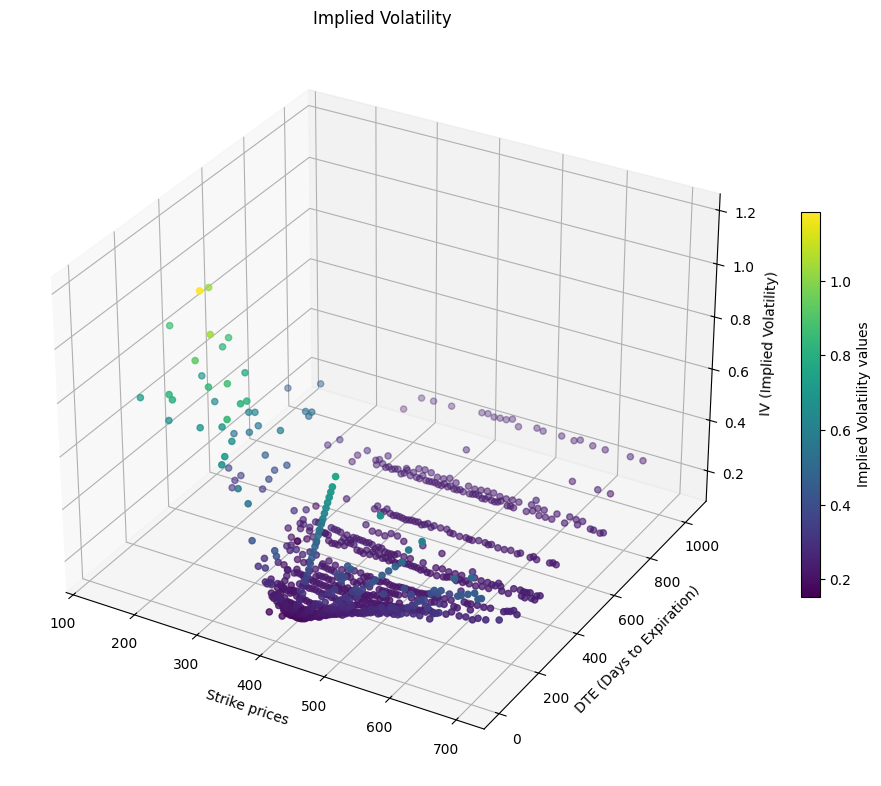

In [144]:
msft.plot_iv_values()

3) Plot implied volatilities on an interactive plot

In [145]:
msft.plot_iv_values_inter()

---------------------------------------------------------------------------------- 
Object was created at: Thursday, 2025-02-06 16:30:30. 
The market is open from 9:30 CET to 22:00 CET (Monday - Friday). 
The IV Calculator is only designed for use during market hours. 
----------------------------------------------------------------------------------


## 2) Analyze past values of volatility (and volatility forecast) for a ticker

In [203]:
msft_vol = VolatilityCalculator("MSFT")

[*********************100%***********************]  1 of 1 completed


1. Plot historical volatilities for the last month based on a required time window (default = 22)

------------------------------------------------------------------------------ 
The last value of historical volatility based on 22-day window is 0.3228. 
------------------------------------------------------------------------------


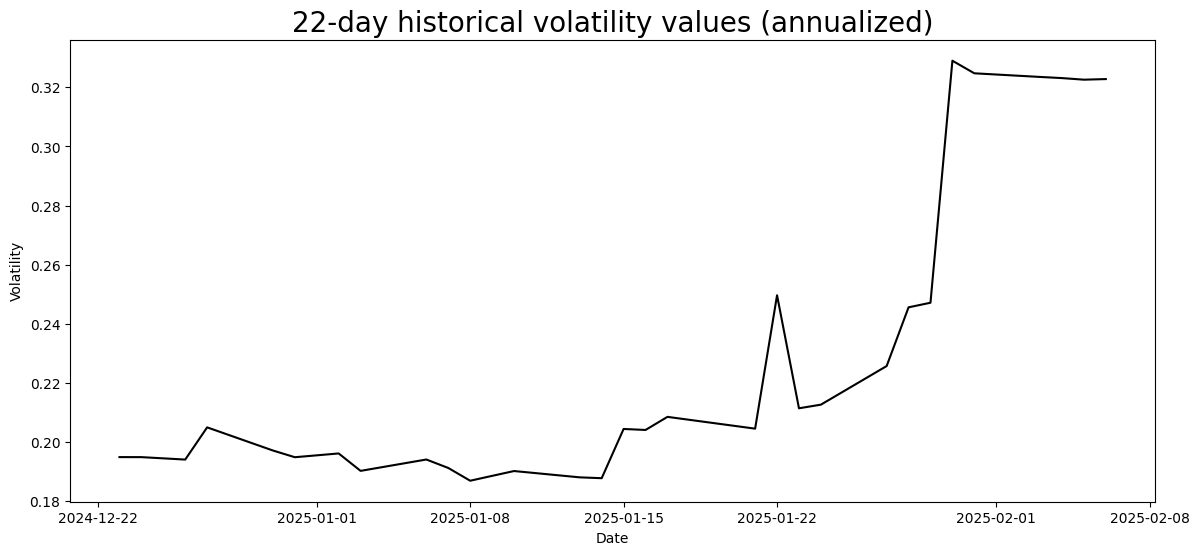

In [204]:
msft_vol.hist_vol()

2) Plot GARCH(1,1) conditional volatility, based on a training period, graph window and a given forecast horizon

------------------------------------------------------------------------------ 
The last value of conditional GARCH(1,1) volatility based on 2000-day 
 training window is 33.323. 
------------------------------------------------------------------------------


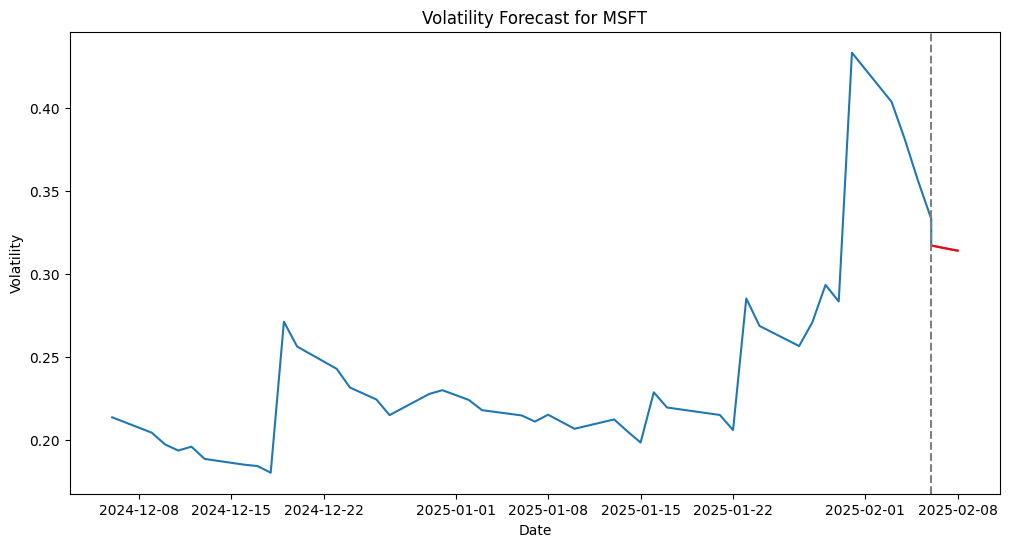

In [205]:
msft_vol.garch_vol(train_period=2000,graph_window=44,forecast_horizon=3)

# 3) If necessary, use Greek calculator to compute required Greeks based on the supplied information 

In [117]:
option1 = OptionGreeksCalculator(0.3,110,100,0.045,14/365,"call")

In [113]:
option1.delta()

np.float64(0.9536126609788667)

In [114]:
option1.gamma()

np.float64(0.015028531499959934)

In [115]:
option1.theta()

np.float64(-0.12613605713213658)

In [116]:
option1.rho()

np.float64(0.03628431594829934)

In [118]:
option1.vega()

np.float64(2.0924656735012706)